# Notebook for comparing ways to save flow data

flow: np.dtype(float32) array of shape (W, H, 2); 
    encodes the velocities (vx, vy) observed by each pixel between two frames
    
formats:
1. python compressed data format (np.save)
2. 16-bit grayscale image for each Vx, Vy (imwrite, PNG)

In [127]:
import os
import sys

import numpy as np
import cv2
import pandas as pd

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
    
# import kinectmatics as km

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper")

In [238]:
def load_flow(fx, fy):
    
    def _load_frame(frame):
        im = cv2.imread(frame, -1)
        return im
    
    imx = _load_frame(fx)
    imy = _load_frame(fy)

    flow = np.stack([imx, imy], axis=2)
    flow = restore_flow(flow)
    return flow

def compress_flow(flow, scale=np.iinfo('uint16').max):# scale=65535.0):
    
    scale_flow = np.copy(flow.astype(np.float64))
    MIN = -175.
    MAX = 175.
    
    scale_flow[:,:,0] = float(scale)*(flow[:,:,0] - MIN) / (MAX - MIN)
    scale_flow[:,:,1] = float(scale)*(flow[:,:,1] - MIN) / (MAX - MIN)
    
    scale_flow = scale_flow.astype(np.uint16)
    return scale_flow

def restore_flow(flow, scale=np.iinfo('uint16').max):
    scaled_flow = np.copy(flow.astype(np.float64))
    MIN = -175.
    MAX = 175.
    
    scaled_flow[:,:,0] = ((scaled_flow[:,:,0] * (MAX - MIN)) / (float(scale))) + MIN #* 255.
    scaled_flow[:,:,1] = ((scaled_flow[:,:,1] * (MAX - MIN)) / (float(scale))) + MIN #* 255.

    scaled_flow = scaled_flow.astype(np.float64) #+ 64.
    return scaled_flow

def process_flow(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return mag, ang

In [247]:
cv2.imwrite?


In [248]:
# load flow in it's various formats

# Original data
# flow = np.load('dat/flow_formats/Flow1.npy')
flow = np.load('C:\\Users\\pgabr\\Documents\\workspace\\kinectmatics\\scripts\\dat\\flow_formats\\Flow1.npy')
vx = flow[:,:,0]
vy = flow[:,:,1]
mag, ang = process_flow(flow)

cmp_flow = compress_flow(flow)
cmp_vx = cmp_flow[:,:,0]
cmp_vy = cmp_flow[:,:,1]
cmp_mag, cmp_ang = process_flow(restore_flow(cmp_flow))

# Image-based data
fx = 'C:\\Users\\pgabr\\Documents\\workspace\\kinectmatics\\scripts\\dat\\flow_formats\\FlowVx_t.png'
fy = 'C:\\Users\\pgabr\\Documents\\workspace\\kinectmatics\\scripts\\dat\\flow_formats\\FlowVy_t.png'

cv2.imwrite(fx, cmp_vx)
cv2.imwrite(fy, cmp_vy)

im_flow = load_flow(fx, fy)
im_vx = im_flow[:,:,0]
im_vy = im_flow[:,:,1]

im_mag, im_ang = process_flow(im_flow)


In [249]:
print(compress_flow(flow).max(), compress_flow(flow).min())
print(flow.dtype, flow.max(), flow.min())
print(cmp_flow.dtype, cmp_flow.max(), cmp_flow.min())

print(im_flow.dtype, im_flow.max(), im_flow.min())

43294 26011
float64 56.22126044576694 -36.082856912029825
uint16 43294 26011
float64 56.2184328984512 -36.08415350576027


Text(0,0.5,'PNG')

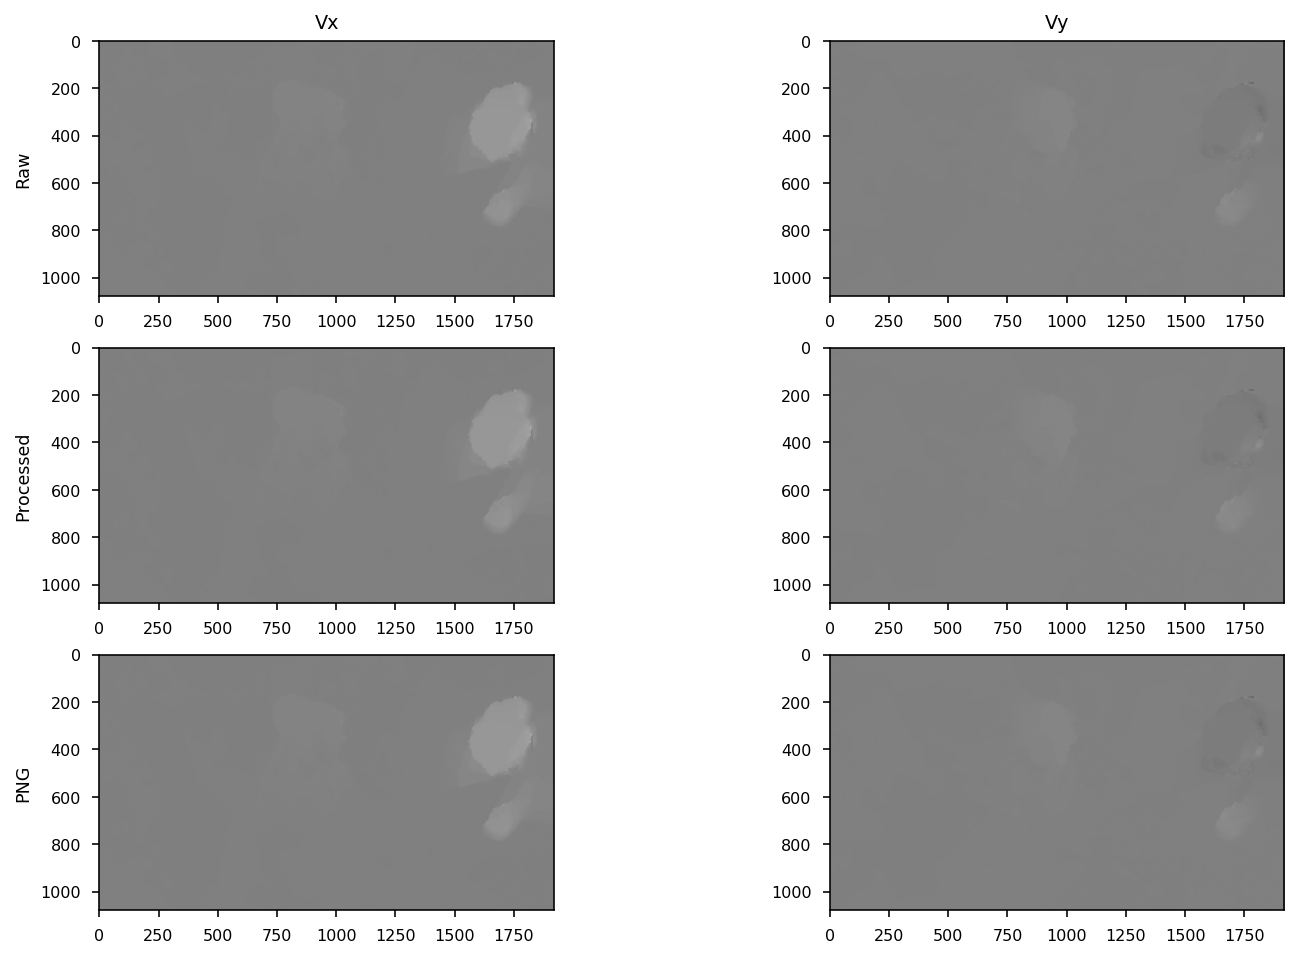

In [258]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax[0,0].imshow(vx, cmap=plt.get_cmap('gray'), vmin=-175., vmax=175.)
ax[1,0].imshow(cmp_vx, cmap=plt.get_cmap('gray'), vmin=0., vmax=65535.)
ax[0,1].imshow(vy, cmap=plt.get_cmap('gray'), vmin=-175., vmax=175.)
ax[1,1].imshow(cmp_vy, cmap=plt.get_cmap('gray'), vmin=0., vmax=65535.)
ax[2,0].imshow(im_vx, cmap=plt.get_cmap('gray'), vmin=-175., vmax=175.)
ax[2,1].imshow(im_vy, cmap=plt.get_cmap('gray'), vmin=-175., vmax=175.)

ax[0,0].set_title('Vx')
ax[0,1].set_title('Vy')

ax[0,0].set_ylabel('Raw')
ax[1,0].set_ylabel('Processed')
ax[2,0].set_ylabel('PNG')




c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


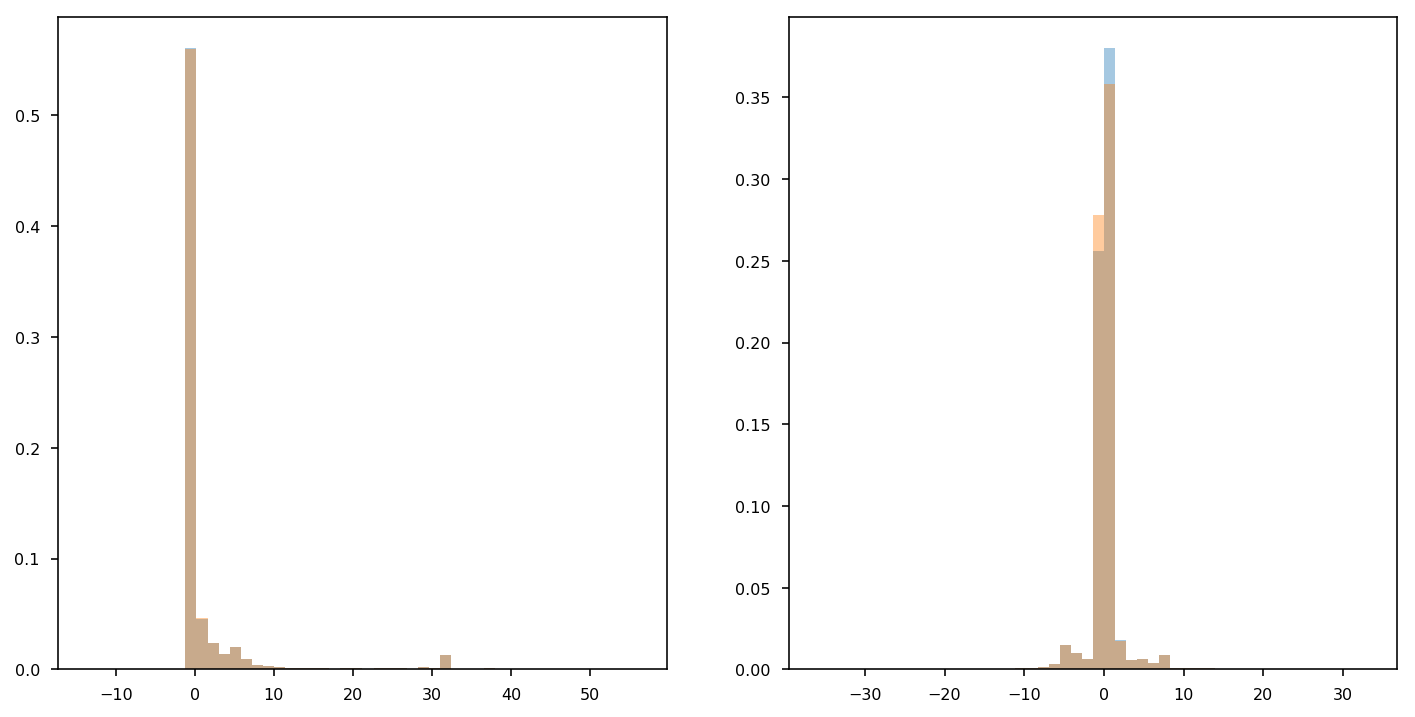

In [259]:
# Compare histograms
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.distplot(vx.ravel(), ax=ax[0], norm_hist=True, kde=False, label='Raw')
sns.distplot(im_vx.ravel(), ax=ax[0], norm_hist=True, kde=False, label='PNG')
ax[0].set_title('')

sns.distplot(vy.ravel(), ax=ax[1], norm_hist=True, kde=False)
sns.distplot(im_vy.ravel(), ax=ax[1], norm_hist=True, kde=False)

Text(0.5,1,'Vy')

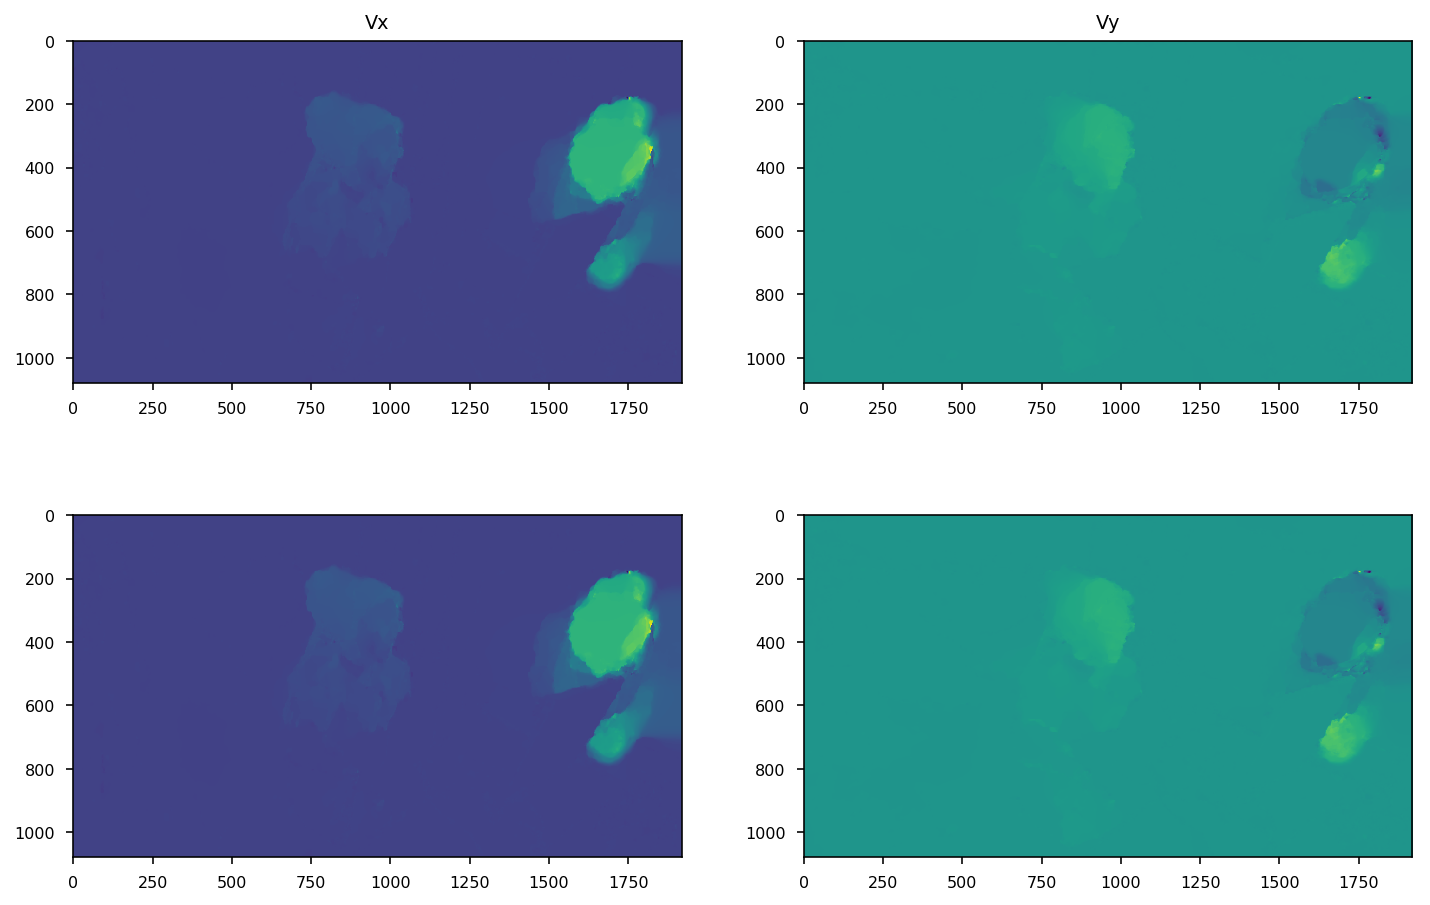

In [260]:

fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].imshow(vx)
ax[1,0].imshow(im_vx)
ax[0,1].imshow(vy)
ax[1,1].imshow(im_vy)

ax[0,0].set_title('Vx')
ax[0,1].set_title('Vy')




c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


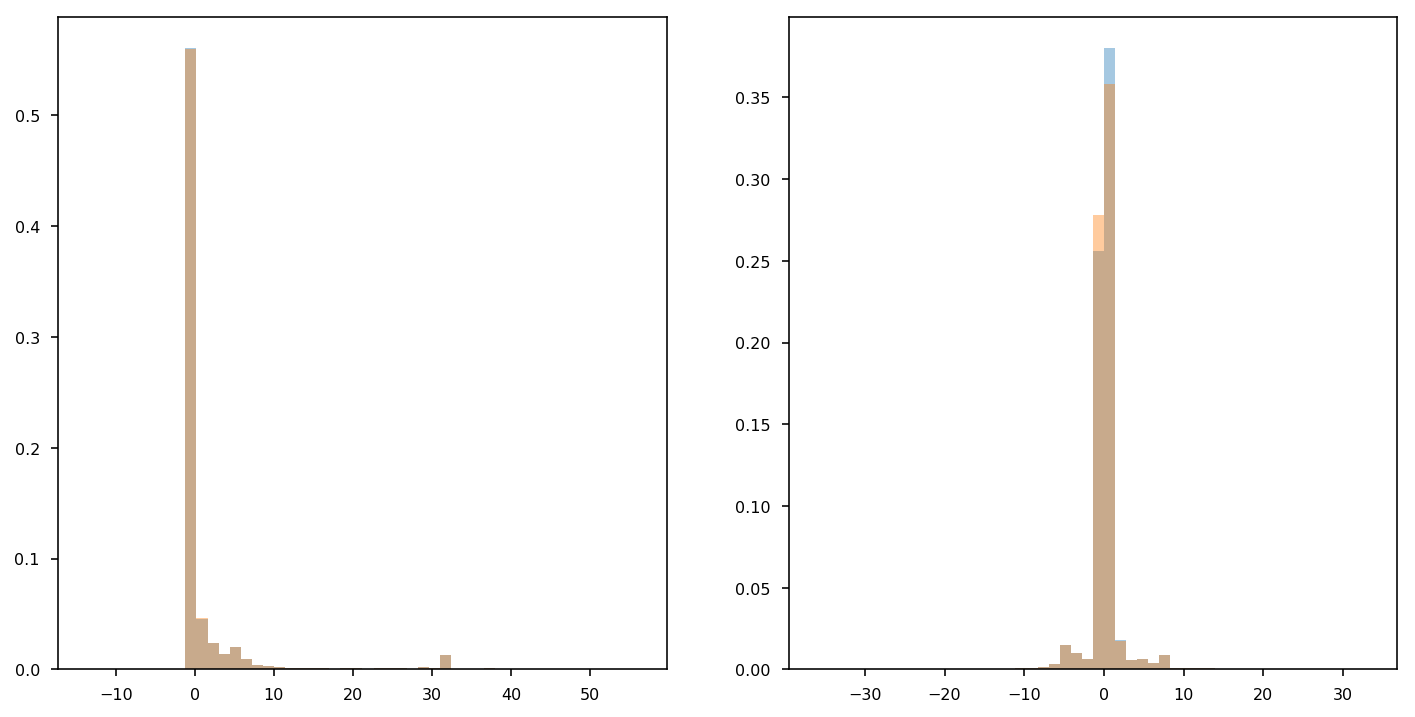

In [261]:
# Compare histograms
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.distplot(vx.ravel(), ax=ax[0], norm_hist=True, kde=False, label='Raw')
sns.distplot(im_vx.ravel(), ax=ax[0], norm_hist=True, kde=False, label='PNG')
ax[0].set_title('')

sns.distplot(vy.ravel(), ax=ax[1], norm_hist=True, kde=False)
sns.distplot(im_vy.ravel(), ax=ax[1], norm_hist=True, kde=False)

c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


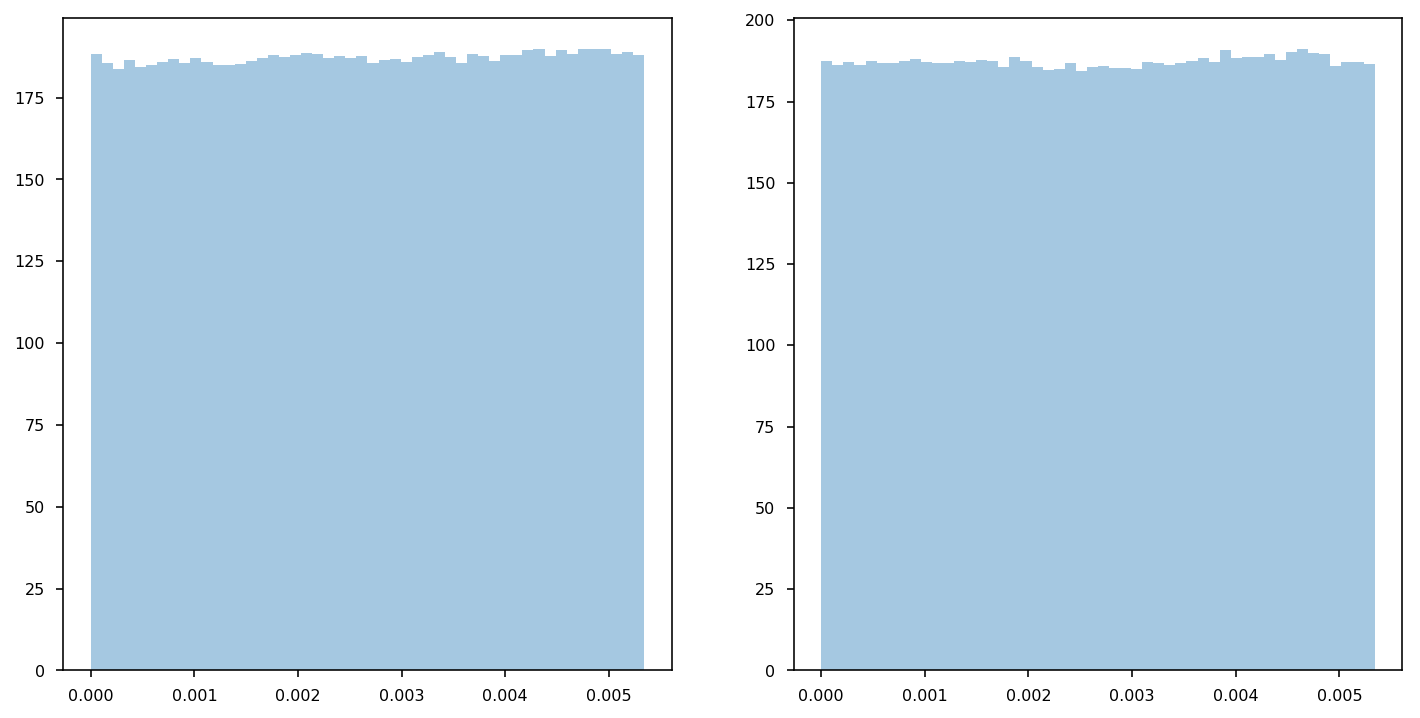

In [262]:
# Compare differences in raw vs reconstructed data
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.distplot(vx.ravel() - im_vx.ravel(), ax=ax[0], norm_hist=True, kde=False, label='Vx_diff')
ax[0].set_title('')

sns.distplot(vy.ravel() - im_vy.ravel(), ax=ax[1], norm_hist=True, kde=False, label='Vy_diff')


In [266]:
# Relationship between reconstruction error and value?
df = pd.DataFrame(vx.ravel(), columns=['Vx'])
df['Vy'] = vy.ravel()
df['Vx_diff'] = vx.ravel() - im_vx.ravel()
df['Vy_diff'] = vy.ravel() - im_vy.ravel()



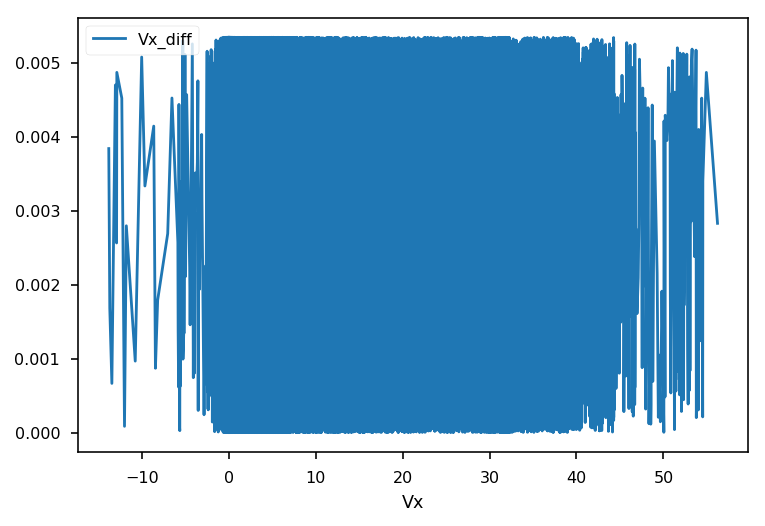

In [265]:
df.sort_values('Vx', inplace=True)

df.plot(x='Vx', y='Vx_diff')


In [257]:
np.min(vy) - np.min(im_vy)

0.0012965937304443287

c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


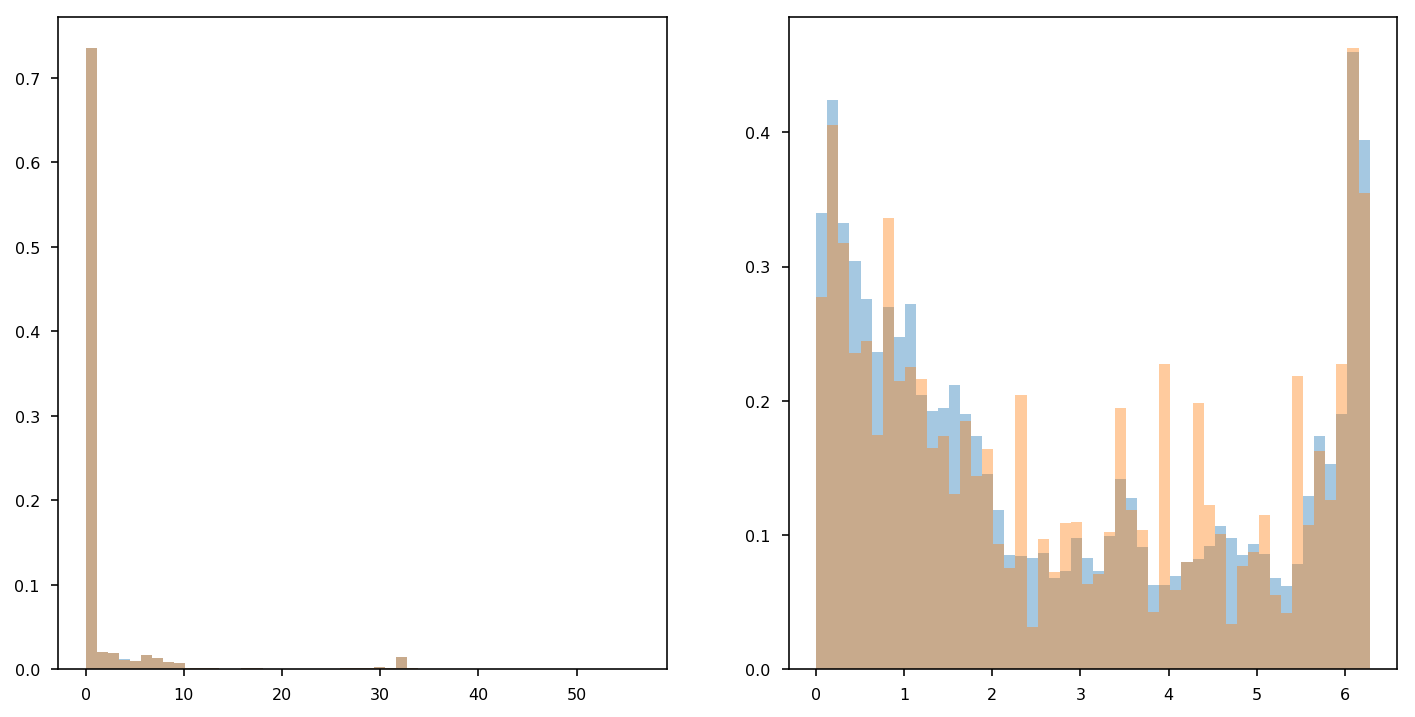

In [263]:
# compare magnitudes
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.distplot(mag.ravel(), ax=ax[0], norm_hist=True, kde=False, label='Raw')
sns.distplot(im_mag.ravel(), ax=ax[0], norm_hist=True, kde=False, label='PNG')
ax[0].set_title('')

sns.distplot(ang.ravel(), ax=ax[1], norm_hist=True, kde=False)
sns.distplot(im_ang.ravel(), ax=ax[1], norm_hist=True, kde=False)

c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\pgabr\anaconda2\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


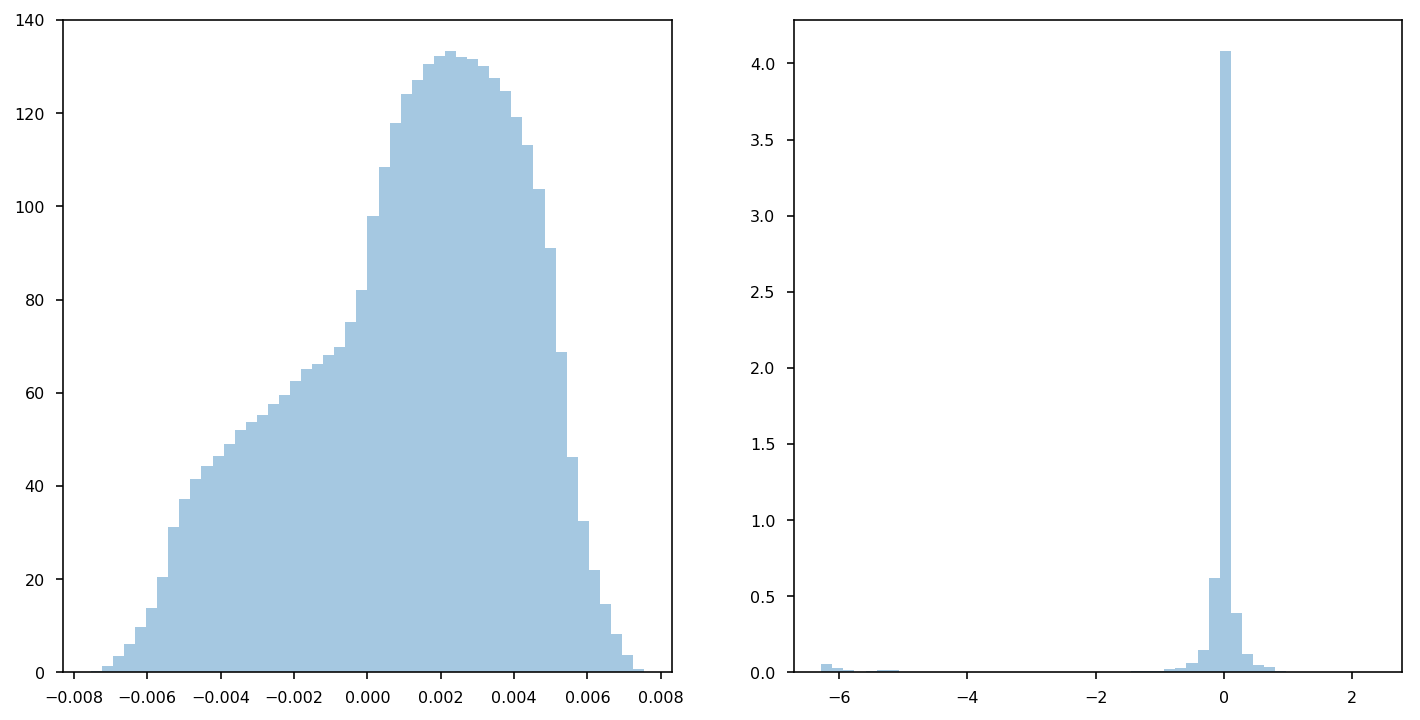

In [264]:
# Compare differences in raw vs reconstructed data (mag, ang)
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.distplot(mag.ravel() - im_mag.ravel(), ax=ax[0], norm_hist=True, kde=False, label='Mag_diff')
ax[0].set_title('')

sns.distplot(ang.ravel() - im_ang.ravel(), ax=ax[1], norm_hist=True, kde=False, label='Ang_diff')
